In [12]:
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.infogram import H2OInfogram
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '..')
from DataModule.Data_Preparation import CoronnaCERTAINDataset
import evaluate
pd.options.mode.chained_assignment = None

In [2]:
dataset = CoronnaCERTAINDataset(
    library_root='/Users/gaskell/Dropbox/Mac/Desktop/Autoimmune_Disease/Code/ML_RA_EHR/Dataset/',
    challenge="regression",
    dataset='CORRONA CERTAIN',
    process_approach='SC',
    imputation='IterativeImputer',
    patient_group='bionaive TNF',
    drug_group='all',
    time_points=(0,3),
    train_test_rate=0.8,
    save_csv=False,
    random_state=2022)

feature engineering, drop columns due to 70% missing value: Index(['smkyrs', 'numcigs', 'rfstatus_impute', 'ccpstatus_impute',
       'statin_use'],
      dtype='object')
save file to: /Users/gaskell/Dropbox/Mac/Desktop/Autoimmune_Disease/Code/ML_RA_EHR/Dataset/.csv_temp/Train.csv
save file to: /Users/gaskell/Dropbox/Mac/Desktop/Autoimmune_Disease/Code/ML_RA_EHR/Dataset/.csv_temp/Test.csv


In [5]:
train, train_loc = dataset.get_train()
test, test_loc = dataset.get_test()

In [7]:
train.head(10)

,grp,age,gender,final_education,race_grp,ethnicity,weight,BMI,height,newsmoker,...,md_global_assess,pt_global_assess,di,pt_pain,usresultsCRP,usresultsIgA,usresultsIgG,usresultsIgM,DAS28_CRP_0M,DAS28_CRP_3M
0,1.0,54.0,1.0,0.0,7.0,1.0,225.0,31.377703,71.0,3.0,...,50.0,25.0,0.285714,25.0,1.640000,144.0,886.0,113.0,3.189429,1.733190
1,1.0,54.0,0.0,0.0,7.0,1.0,175.0,28.242654,66.0,3.0,...,35.0,17.0,0.250000,25.0,1.190000,207.0,1010.0,56.0,2.935127,2.473876
2,1.0,63.0,0.0,0.0,7.0,1.0,117.0,20.080811,64.0,0.0,...,40.0,10.0,0.000000,5.0,0.400000,190.0,657.0,100.0,2.698947,3.386822
3,1.0,61.0,0.0,0.0,7.0,1.0,240.0,39.933728,65.0,2.0,...,55.0,50.0,0.250000,60.0,1.000000,44.0,948.0,51.0,3.719481,4.444948
4,1.0,64.0,1.0,0.0,7.0,1.0,294.0,41.000198,71.0,2.0,...,55.0,55.0,0.285714,70.0,16.740000,178.0,882.0,87.0,5.146565,2.846272
5,2.0,51.0,0.0,2.0,7.0,1.0,90.0,18.175812,59.0,0.0,...,65.0,20.0,0.250000,65.0,0.250000,155.0,824.0,43.0,4.425214,3.143985
6,3.0,57.0,0.0,0.0,7.0,1.0,161.0,30.417361,61.0,3.0,...,70.0,55.0,1.000000,65.0,10.652464,273.0,714.0,138.0,5.133986,1.521586
7,2.0,62.0,0.0,0.0,7.0,1.0,150.0,26.568405,63.0,2.0,...,50.0,25.0,0.000000,20.0,17.930000,171.0,992.0,95.0,5.278515,1.960279
8,1.0,54.0,1.0,2.0,7.0,1.0,182.0,25.381075,71.0,0.0,...,40.0,10.0,0.142857,5.0,4.700000,267.0,1110.0,109.0,3.604865,1.532090
9,1.0,50.0,0.0,0.0,7.0,1.0,250.0,39.151259,67.0,2.0,...,35.0,27.0,0.500000,20.0,1.330000,402.0,1290.0,89.0,3.809990,3.370891


In [73]:
# Start the H2O cluster (locally)
h2o.init()

# Import a sample binary outcome train/test set into H2O
train = h2o.upload_file(str(train_loc))
test = h2o.upload_file(str(test_loc))

# Identify predictors and response
x = train.columns[:-1]
y = "DAS28_CRP_3M"

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,20 mins 20 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,1 month
H2O_cluster_name:,H2O_from_python_gaskell_eeern4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.855 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [33]:
# Run AutoML for 20 base models
aml = H2OAutoML(max_runtime_secs = 60, seed = 1, project_name = "EHR_RA_SC_reg_2")
aml.train(x=x, y=y, training_frame=train, leaderboard_frame = test)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

AutoML progress: |
23:54:22.285: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, num_tnf, num_nontnf]


23:54:22.981: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, num_tnf, num_nontnf]


23:54:23.364: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, num_tnf, num_nontnf]

█
23:54:23.903: _train param, Dropping unused columns: [pres_imuran, pres_minocin, num_tnf, num_nontnf]
23:54:24.28: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, num_tnf, num_nontnf]
23:54:24.291: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, num_tnf, num_nontnf]

██
23:54:25.397: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, num_tnf, num_nontnf]

█
23:54:25.950: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, num_tnf, num_nontnf]

█
23:54:26.359: _train param, Dropping bad and constant columns: [pres_imuran, pr

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
DeepLearning_grid_3_AutoML_3_20220626_235422_model_3,1.10647,1.22427,0.926287,0.259163,1.22427
XGBoost_lr_search_selection_AutoML_3_20220626_235422_select_grid_model_2,1.11833,1.25065,0.944743,0.259413,1.25065
StackedEnsemble_BestOfFamily_4_AutoML_3_20220626_235422,1.16392,1.35472,0.972527,0.268225,1.35472
DeepLearning_grid_2_AutoML_3_20220626_235422_model_3,1.16452,1.35611,0.967123,0.264104,1.35611
StackedEnsemble_BestOfFamily_5_AutoML_3_20220626_235422,1.16869,1.36585,0.970174,0.268222,1.36585
DRF_1_AutoML_3_20220626_235422,1.17042,1.36989,0.951408,0.269338,1.36989
DeepLearning_grid_1_AutoML_3_20220626_235422_model_3,1.17702,1.38537,0.954955,0.27296,1.38537
DeepLearning_grid_2_AutoML_3_20220626_235422_model_1,1.18274,1.39886,0.956027,0.267672,1.39886
XRT_1_AutoML_3_20220626_235422,1.18544,1.40527,0.980389,0.27506,1.40527
StackedEnsemble_BestOfFamily_3_AutoML_3_20220626_235422,1.18678,1.40845,0.983758,0.271416,1.40845


In [74]:
pred = aml.predict(test)
pred.head()

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


predict
2.36293
3.88212
3.09518
2.13975
3.55914
3.50373
3.59352
3.82611
3.43633
3.27991


In [75]:
aml_self = evaluate.AutoBuild(seed=1, project_name="EHR_RA_SC")
test, test_loc = dataset.get_test()
baseline = test['DAS28_CRP_0M']
true = test['DAS28_CRP_3M']

In [76]:
pred = pred.as_data_frame()
type(pred)

pandas.core.frame.DataFrame

In [77]:
aml_self.evaluate("gbm", baseline, true, pred)

In [78]:
regression, classification = aml_self.leaderboard()

In [81]:
regression

,model,MAE,MSE,RMSE,R2,Pearson_Correlation
0,gbm,1.325212,2.612861,1.616435,0.378155,[0.621274935463593]


In [79]:
classification

,model,Accuracy
0,gbm,0.488372


In [80]:
perf = aml.leader.model_performance(test)
perf

TypeError: can only concatenate str (not "type") to str

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
GBM_grid_1_AutoML_1_20220615_224006_model_11,1.01684,1.03397,0.793286,0.256111,1.03397,49,0.260782,GBM
StackedEnsemble_BestOfFamily_4_AutoML_1_20220615_224006,1.04426,1.09047,0.819373,0.261257,1.09047,134,0.534149,StackedEnsemble
StackedEnsemble_BestOfFamily_5_AutoML_1_20220615_224006,1.0507,1.10397,0.825159,0.262968,1.10397,119,0.170608,StackedEnsemble
GLM_1_AutoML_1_20220615_224006,1.06194,1.12772,0.823217,0.266955,1.12772,61,0.023002,GLM
StackedEnsemble_AllModels_3_AutoML_1_20220615_224006,1.06241,1.12871,0.835599,0.267402,1.12871,273,1.56138,StackedEnsemble
DeepLearning_grid_3_AutoML_1_20220615_224006_model_3,1.06414,1.13239,0.827168,0.263884,1.13239,25,0.103544,DeepLearning
StackedEnsemble_BestOfFamily_1_AutoML_1_20220615_224006,1.06448,1.13312,0.824628,0.267247,1.13312,267,0.272979,StackedEnsemble
DeepLearning_grid_3_AutoML_1_20220615_224006_model_1,1.06799,1.1406,0.823998,0.264931,1.1406,87,0.055435,DeepLearning
XGBoost_grid_1_AutoML_1_20220615_224006_model_49,1.07617,1.15813,0.846191,0.267318,1.15813,74,0.050045,XGBoost
StackedEnsemble_AllModels_4_AutoML_1_20220615_224006,1.07631,1.15845,0.860622,0.269278,1.15845,153,0.540981,StackedEnsemble


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

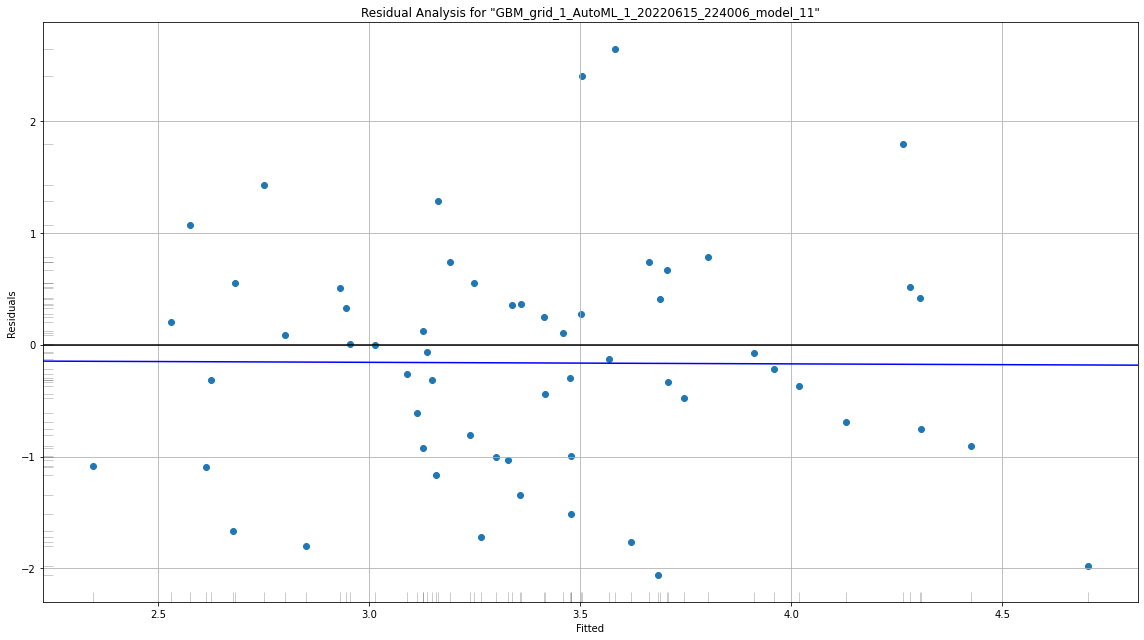

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

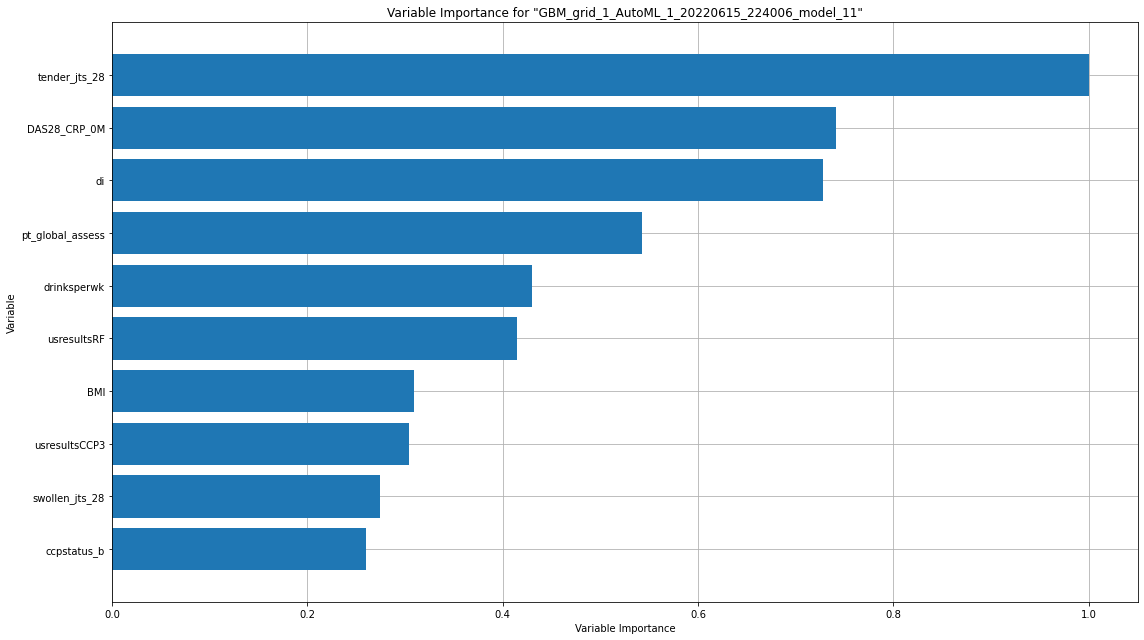

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

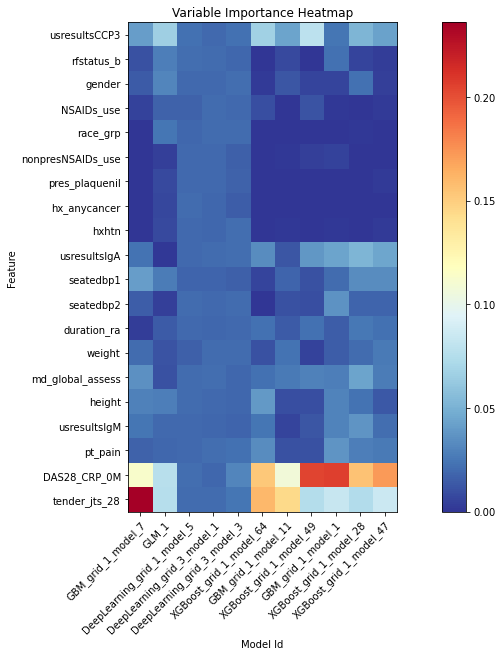

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

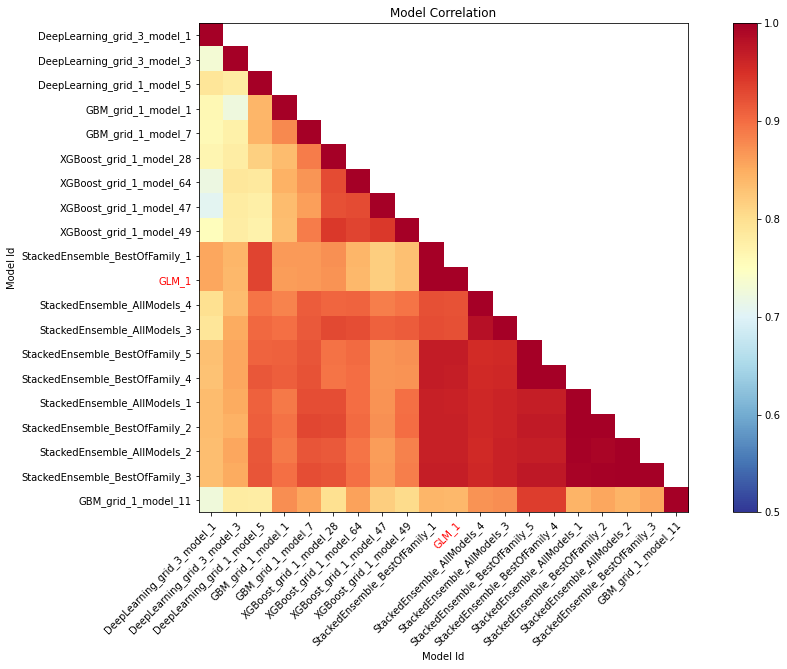

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

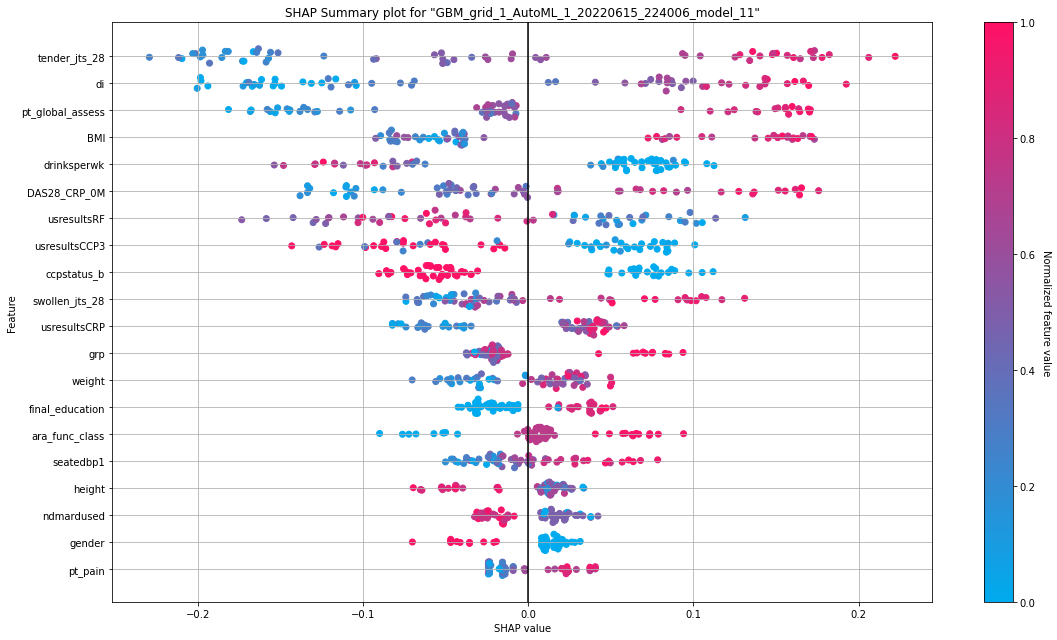

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

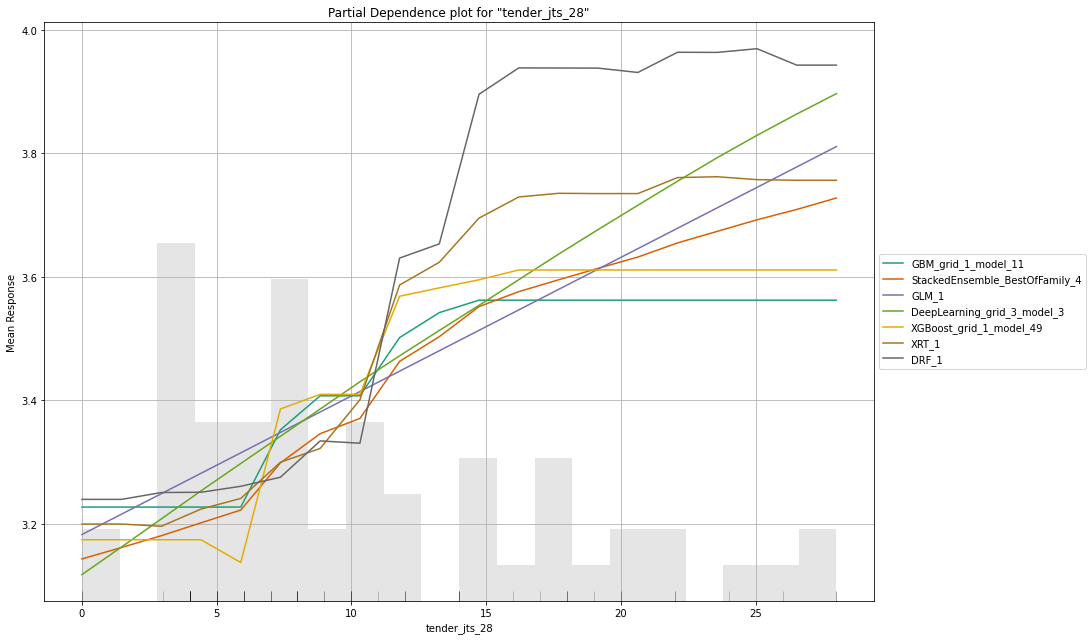

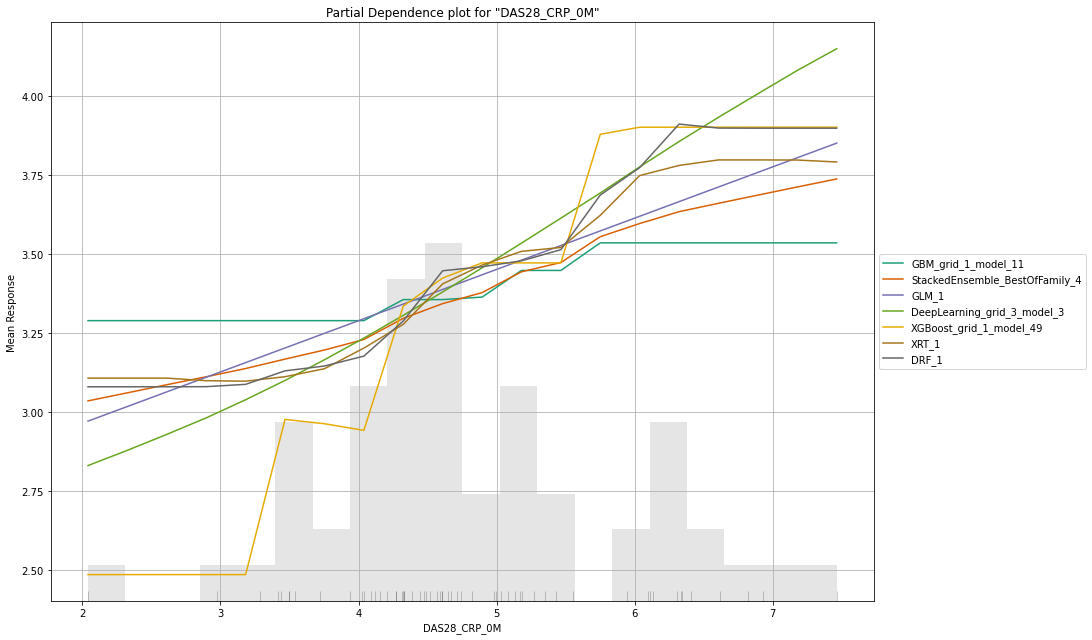

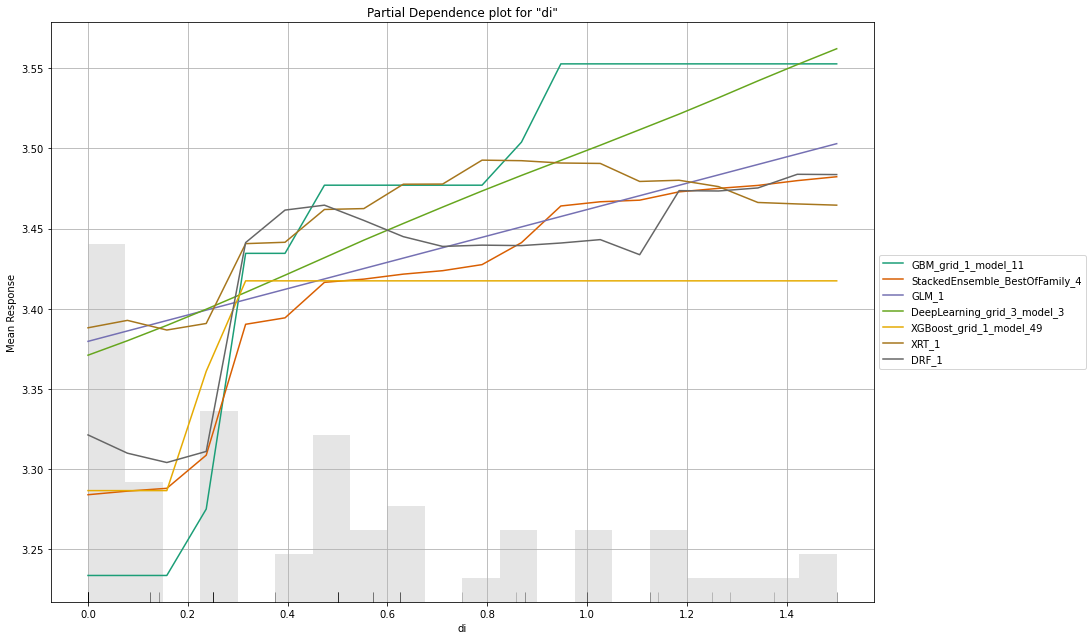

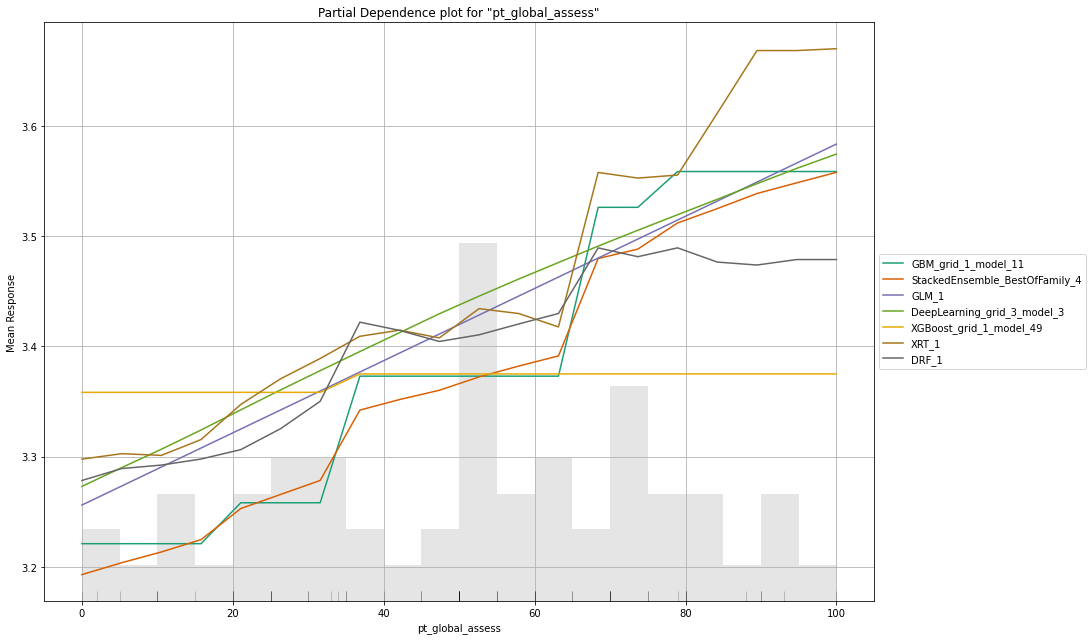

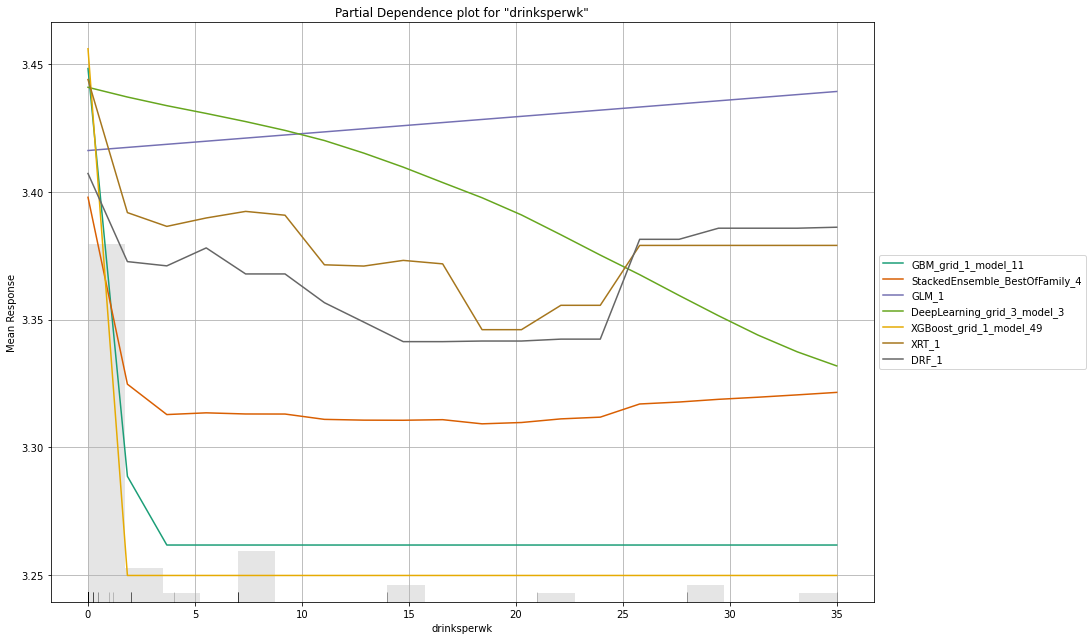

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

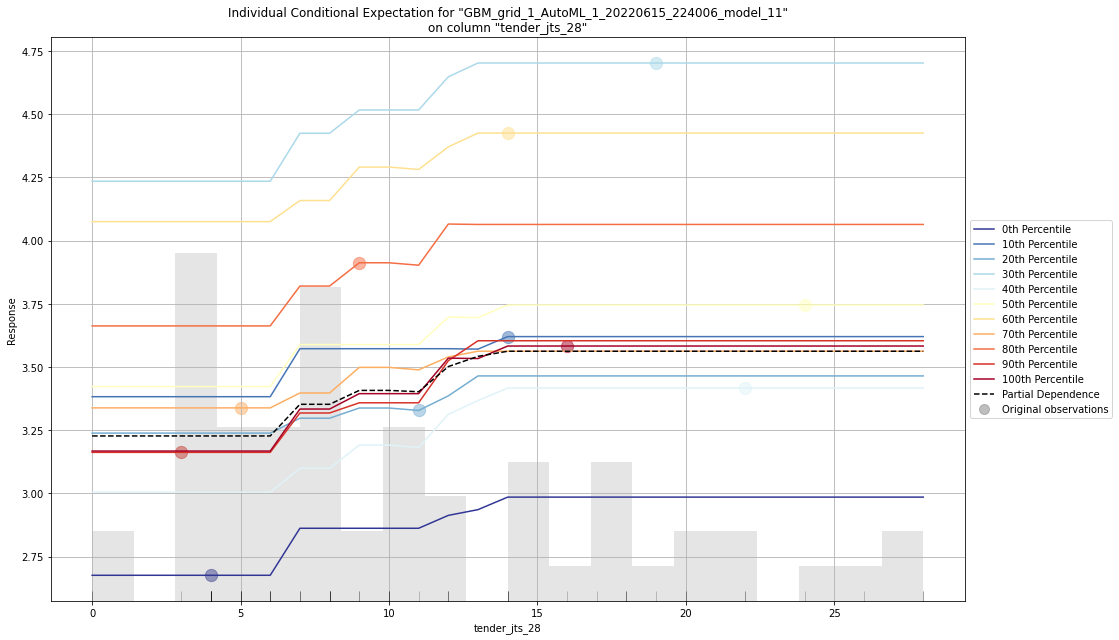

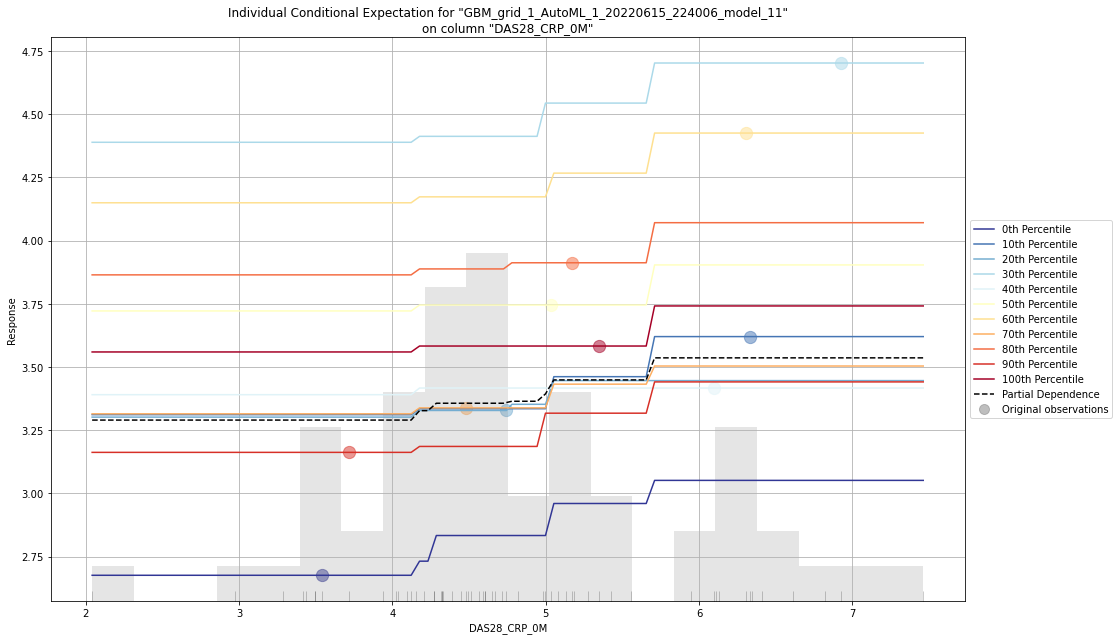

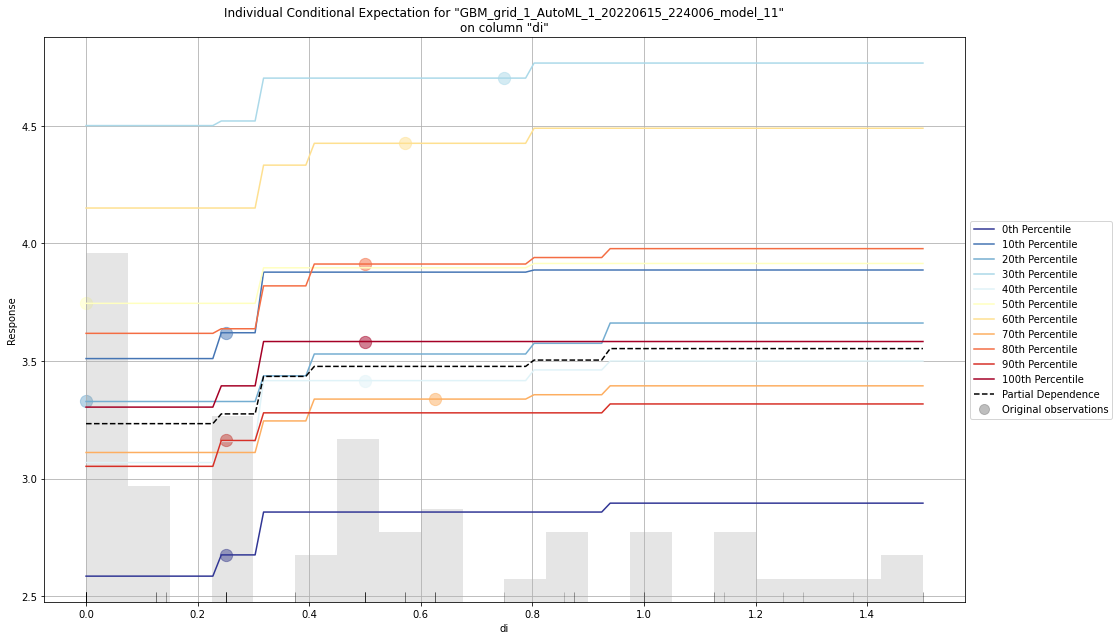

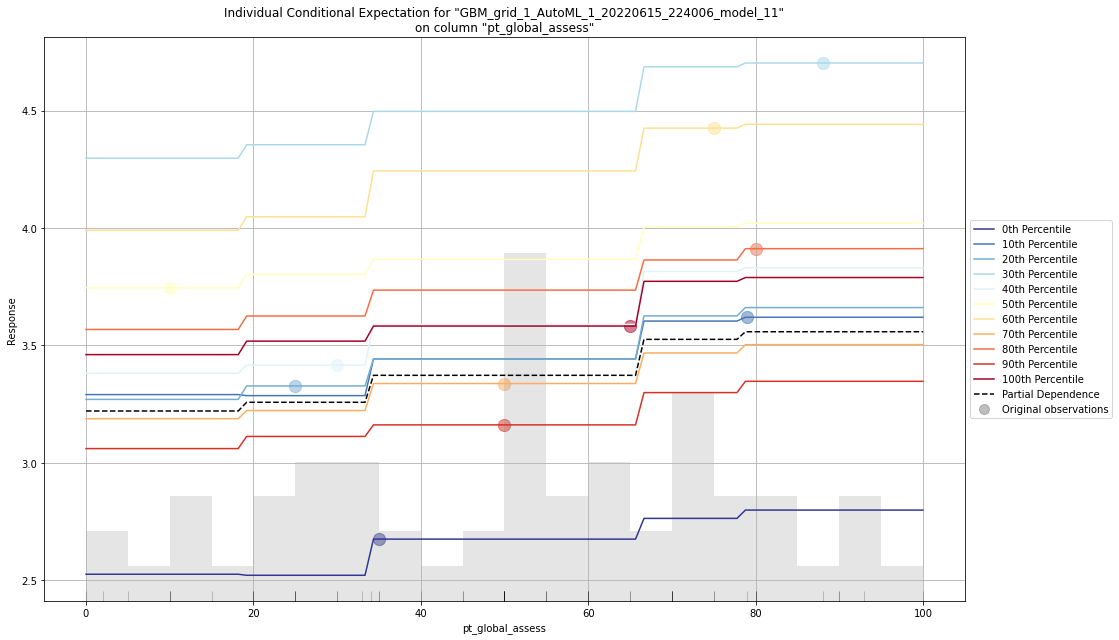

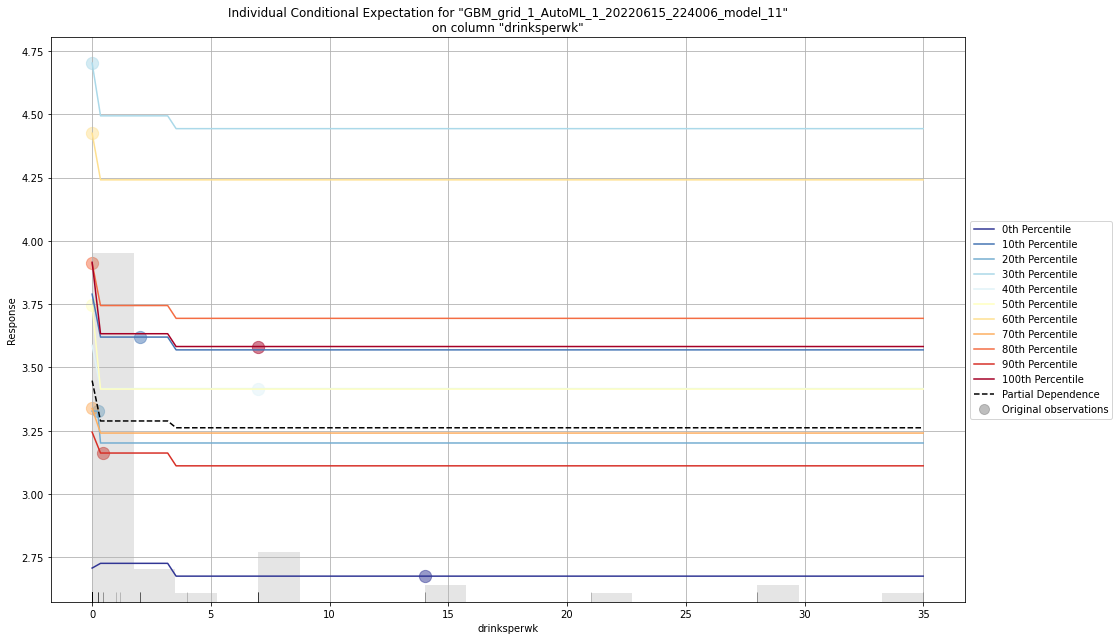

In [10]:
# Explain an AutoML object
exa = aml.explain(test)